In [1]:
import matplotlib as mpl
import os, sys
mpl.use('Agg')
from LiteNet import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from time import time
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm, trange
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

In [2]:
from nystrom_kexpfam.data_generators.Gaussian import GaussianGridWrapped
from nystrom_kexpfam.data_generators.Ring import Ring
#from nystrom_kexpfam.data_generators.Dataset import GlassPosteriorDataset

from nystrom_kexpfam.log import logger
from nystrom_kexpfam.visualisation import visualise_array_2d

from nystrom_kexpfam.estimators.KMCLite import KMCLite

INFO: 2018-05-04 16:02:30,187: log.<module>(): Global logger initialised with loglevel 20
INFO: 2018-05-04 16:02:30,253: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handl

In [3]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
def gen_data(n):
    
    rand_data = p.sample(n)
    
    return rand_data

In [10]:
npoint = 500
lam = 10**(tf.Variable(-1, dtype="float32"))
lam2 = tf.identity(lam)
#lam2= 10**(tf.constant(-1, dtype="float32"))
#lam3= 10**(tf.constant(-2, dtype="float32"))
lam3 = tf.constant(-50, dtype="float32")
sigma = 10**(tf.Variable(-1, dtype="float32"))

s = 10


plot_size = 12

net_type = "i"

step_size = 3e-2
init_std = 1e-1

niter = 1000

ndim = (50,)

batch_size = 500
ntrain = npoint
nval = 300
seed = 1

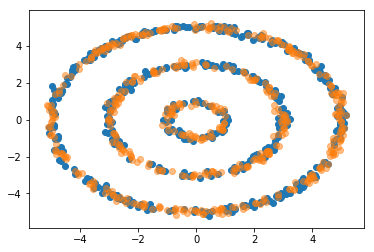

In [11]:
#np.random.seed(seed)

#rand_val_data1 = np.array([[xv,yv] for xv in np.linspace(-6,2,10) for yv in np.linspace(-7,-2,10)])
#rand_val_data2 = np.array([[xv,yv] for xv in np.linspace(2,7,10) for yv in np.linspace(-2,6,10)])
#rand_train_data = np.r_[rand_val_data1, rand_val_data2]
rand_train_data = gen_data(ntrain)
rand_points = gen_data(npoint)

ndim_in = (rand_train_data.shape[1],)


np.random.shuffle(rand_train_data)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1])
plt.scatter(rand_points[:,0],rand_points[:,1], alpha=0.5);

In [12]:
ngrid = 100

np.random.seed(1)


npoint = 500
lam = 10**(tf.Variable(-3, dtype="float32"))
sigma = 10**(tf.Variable(0, dtype="float32"))
 

lam2 = tf.identity(lam)
lam3= 10**(tf.constant(-50, dtype="float32"))


if D == 2:
    eval_points = np.array([[xv,yv] 
            for xv in np.linspace(-plot_size/2,plot_size/2,ngrid) 
                            for yv in np.linspace(-plot_size/2,plot_size/2,ngrid)])
    
print '=====building kernel'
kernel  = GaussianKernel(sigma)
kn = KernelModel(kernel)
kn.alpha = tf.Variable(np.zeros(npoint, dtype="float32"))
    
points  = tf.placeholder("float32", shape=(npoint, D), name="points")

kn.set_points(points)

loss, score, train_data, val_data, r_norm, l_norm, curve, alpha_assign = \
    kn.val_score(lam=lam, lam2=lam2, lam3=lam3)

test_data = tf.placeholder("float32", shape=(None, D), name="test_data")
fv = kn.evaluate_fun(test_data)
gv = kn.evaluate_grad(test_data)

=====building kernel


In [13]:

#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1000)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True

In [14]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)



#feed[val_data] = gen_data(nval)
alpha_opt, _, score, train_data = kn.opt_score(lam=lam, lam2=lam)[:4]
np.random.seed(1)
niter = 100
feed={}
scores = np.zeros(niter)
for ni in trange(niter):
    feed[train_data] = gen_data(ntrain)
    feed[points] = feed[train_data]
    feed[test_data] = gen_data(5000)

    test_batch_size = 500

    sess.run(alpha_opt, feed_dict=feed)

    nbatch = 5000/test_batch_size

    for i in range(nbatch):
        d = gen_data(test_batch_size)
        feed[test_data] = d 
        gt = p.grad_multiple(d)
        ge = gv.eval(feed_dict=feed)
        scores[ni] += 0.5 * np.mean(np.sum((gt-ge)**2,1))/nbatch
#scores/= nbatch * niter


plt.hist([scores_gs,scores_cv],bins=50,alpha=0.8)

In [79]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam2s  = np.zeros(niter+1)
lam3s  = np.zeros(niter+1)

fvs = []
rand_val_data = gen_data(nval)
rand_test_data = gen_data(nval)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
test_grad_true = p.grad_multiple(rand_test_data)

init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)
t0 = time()

feed[val_data] = gen_data(nval)


for i in range(niter+1):


    feed[train_data] = gen_data(ntrain)
    feed[points] = feed[train_data]

    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points,
                                         points: feed[train_data]})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val = sess.run([score, r_norm, l_norm, 
                                                                        curve, kn.alpha], 
        feed_dict=feed)

    sigmas[i], lams[i], lam2s[i] ,lam3s[i]  = sess.run([sigma, lam, lam2, lam3])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='
        
        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        print 'true score', 0.5*np.mean(np.sum((test_grad_true - gv_val)**2,1))
        print 'sigma: %.5f' % sigma.eval()
        print 'lam, lam2, lam3', lam.eval(), lam2.eval(), lam3.eval()
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val


Iteration     0, score -8.53 ( -0.5), time taken 0.42
true score 41.3983312884
sigma: 0.93325
lam, lam2, lam3 0.000933254 0.000933254 0.0
alpha: 0.67478
rn, ln, c =  6005.03 1587.35 118.437
Iteration   100, score -40.2 ( -0.5), time taken 15.91
true score 6.27597708877
sigma: 0.45073
lam, lam2, lam3 0.000224253 0.000224253 0.0
alpha: 3.2743
rn, ln, c =  80925.4 15483.6 5853.5
Iteration   200, score -40.5 ( -0.5), time taken 30.62
true score 6.89604003407
sigma: 0.43603
lam, lam2, lam3 0.000189501 0.000189501 0.0
alpha: 3.5621
rn, ln, c =  93142.8 19264.9 6779.59
Iteration   300, score -45.8 ( -0.5), time taken 45.33
true score 8.67056739566
sigma: 0.44119
lam, lam2, lam3 0.000184946 0.000184946 0.0
alpha: 3.5539
rn, ln, c =  92260.3 22946.5 6455.38
Iteration   400, score -42.3 ( -0.5), time taken 59.33
true score 9.48670999251
sigma: 0.45309
lam, lam2, lam3 0.000179111 0.000179111 0.0
alpha: 3.6931
rn, ln, c =  101557.0 25342.5 6672.12


KeyboardInterrupt: 

cv model score:  -44.0351
cv true score:   7.31601593281
gs model score:  -43.9516683775
gs true score:   7.49159756965


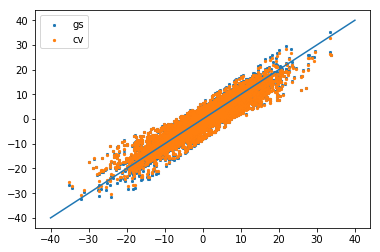

In [63]:
#np.random.seed(3)
batch_size = 500
rand_train_data = gen_data(batch_size)
rand_test_data = gen_data(batch_size*10)

ge_kn = []
sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                              test_data: d, 
                                              points:rand_train_data,
                                              val_data: d})
    ge_kn += [o1]
    sc += [o2]

ge_kn = np.concatenate(ge_kn,0)
gt = p.grad_multiple(rand_test_data)
print "cv model score: ", np.mean(sc)
print "cv true score:  ", 0.5*np.mean(np.sum((ge_kn-gt)**2,1))


est = KMCLite(m = 500, sigma = np.exp(0.1224), lmbda = np.exp(-4.1224))
#est = KMCLite(m = 500, sigma = 10**(-0.2564), lmbda = 10**(-4.0513))

est.fit(rand_train_data)

ge = est.grad(rand_test_data)

sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "gs model score: ", np.mean(sc)
print "gs true score:  ", 0.5*np.mean(np.sum((ge-gt)**2,1))
plt.scatter(gt.flatten(), ge.flatten(), 5, marker='x');
plt.scatter(gt.flatten(), ge_kn.flatten(), 5, marker='o');
plt.legend(["gs","cv"])
plt.plot([-40,40],[-40,40])

MannwhitneyuResult(statistic=12362821.0, pvalue=0.17096645586769671)


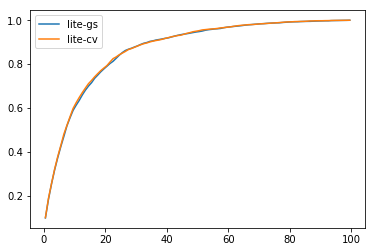

In [64]:
from scipy.stats import mannwhitneyu, ttest_rel, wilcoxon

def plot_error_cdf(data, bins = 10, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    counts, _ = np.histogram(data, bins=bins, normed=True)
    centers = 0.5*(bins[1:]+bins[:-1])
    cdf    = np.cumsum(counts)
    ax.plot(centers, cdf)
    
fig, ax = plt.subplots()
bins = np.linspace(0,100,101)

lite_errors = np.sum((ge-gt)**2,1)
kn_errors = np.sum((ge_kn-gt)**2,1)

plot_error_cdf(lite_errors, bins = bins, ax=ax)
plot_error_cdf(kn_errors, bins = bins, ax=ax)
plt.legend(["lite-gs","lite-cv"])
a = wilcoxon(lite_errors, kn_errors)
print mannwhitneyu(lite_errors, kn_errors)

In [65]:
import h5py as h5 
with h5.File("results/param_search/Ring_D2_rep100_res50.h5","r") as f:
    print f.keys()
    grid_scores = f["scores"].value
    grid_all_scores = f["all_scores"].value
    Y = f["lams"].value
    X = f["scores"].value

[u'all_scores', u'lams', u'scores', u'sigs']


(-4.5, -3.5)

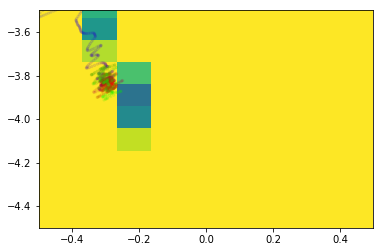

In [73]:
plt.pcolormesh(X, Y, np.log10(grid_scores).T, vmin=np.log10(7.5),vmax=np.log10(8.2))
plt.scatter(log_sigams[traj_idx],log_lambdas[traj_idx],  np.ones(len(traj_idx))*5, colors,
           marker="o", zorder=2, alpha=0.1);

plt.xlim([-0.5,0.5])
plt.ylim([-4.5,-3.5])

In [67]:
X[best_ind[0]], Y[best_ind[1]]

(array([ 43.983,  41.586,  39.286,  37.053,  35.082,  33.082,  31.262,  29.56 ,  27.931,  26.418,  24.982,  23.633,
         22.363,  21.152,  20.013,  18.924,  17.891,  16.9  ,  15.947,  15.025,  14.129,  13.254,  12.397,  11.558,
         10.745,   9.969,   9.252,   8.626,   8.133,   7.825,   7.759,   7.993,   8.583,   9.569,  10.976,  12.801,
         15.019,  17.573,  20.383,  23.354,  26.38 ,  29.359,  32.203,  34.841,  37.227,  39.337,  41.166,  42.725,
         44.035,  45.123]), -3.9387755)

In [77]:
grid_scores.shape

(50, 50)

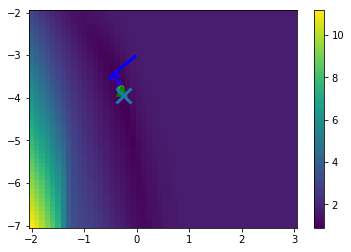

In [78]:
fig, ax = plt.subplots()
X = np.linspace(-2,3,50, dtype="float32")
Y = np.linspace(-7,-2,50, dtype="float32")

dX = X[1]-X[0]
dY = Y[1]-Y[0]

def linedge(grid):
    d = grid[2]-grid[1]
    return np.r_[grid-d/2, grid[-1]+d/2]

visualise_array_2d(linedge(X), linedge(Y), np.log10(grid_scores), ax=ax)

cm = plt.get_cmap("brg")

log_sigams = np.log10(sigmas)
log_lambdas = np.log10(lam2s)

#ax.plot(log_sigams,log_lambdas,zorder=3, marker='.', lw=2);
traj_idx = np.arange(0,5*niter/5,1)
colors = cm(np.linspace(0,1, len(traj_idx)))

ax.scatter(log_sigams[traj_idx],log_lambdas[traj_idx],  np.ones(len(traj_idx))*5, colors,
           marker="o", zorder=2);
#ax.plot(log_sigams[0], log_lambdas[0], "x", ms=10, c="b")

ax.plot(log_sigams[-1], log_lambdas[-1], "^", ms=10, mew=2,c="g", alpha=0.8)

best_ind = np.unravel_index(np.nanargmin(grid_scores), grid_scores.shape)
plt.plot(X[best_ind[0]], Y[best_ind[1]], 'x', markersize=15, mew=3)

#ax.set_xlim([-0.5,0.5])
#ax.set_ylim([-4.5,-3.5])

In [122]:
X[best_ind[0]], Y[best_ind[1]]

(-0.26530612, -3.9387755)

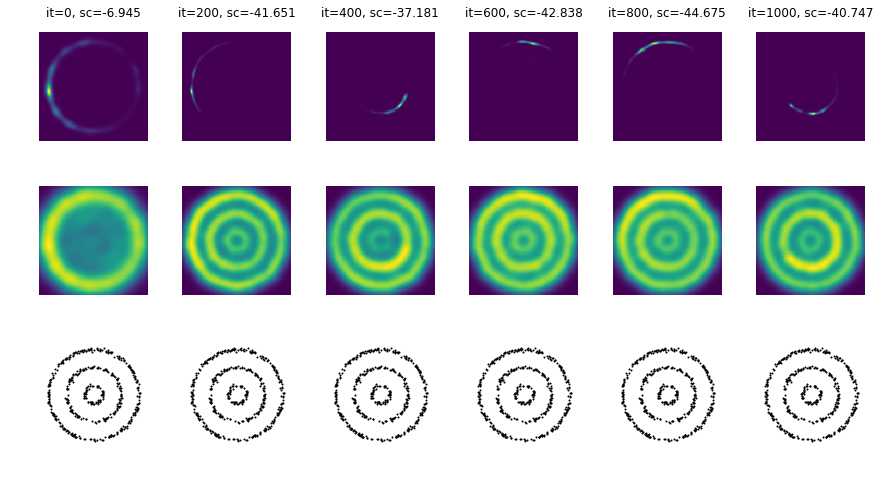

In [123]:

nfvs  = len(fvs)
fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
vmin = min(map(np.min, fvs))
vmax = max(map(np.max, fvs))

for i in range(len(fvs)):

    iter_number = niter/5*i
    ax = axes[0, i]

    hist = (fvs[i])

    ax.imshow( hist.reshape(ngrid, ngrid).T)
    ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
    ax.set_axis_off()

    ax = axes[1, i]
    ax.imshow( np.log(hist).reshape(ngrid, ngrid).T)
    ax.set_axis_off()


    ax = axes[2, i]
    ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
    ax.set_axis_off()


#plt.show()
#fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
#fig.savefig("figs/grid_dist/test.pdf") 


/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


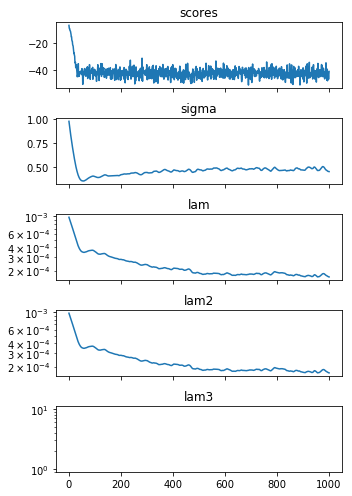

In [124]:

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 